# Advanced Lane Finding Project:

## Import Dependencies

In [168]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Load Images and Find Corners

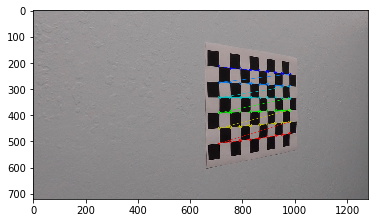

In [169]:
def load_calibration_images():
    paths = glob.glob('camera_cal/*.jpg')
    return np.array([cv2.imread(path) for path in paths])

objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

def to_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def find_corners(image, name = None):
    ret, corners = cv2.findChessboardCorners(to_gray(image), (9, 6), None)
    if not ret:
        print('could not find corners in image: {}'.format(name))
        return 
    
    return corners
            
def draw(image, corners):
    if corners is None:
        print('no corners to draw')
    painted = cv2.drawChessboardCorners(image, (9, 6), corners, True)
    plt.imshow(painted)

            
images = load_calibration_images()
image_num = 19

image = images[image_num]
corners = find_corners(image, image_num)
draw(image, corners)

# Get Points and Define Calibrate 

In [170]:


def get_points(images):
    obj_points = []
    img_points = []
    
    for i, image in enumerate(images):
        corners = find_corners(image, i)
        if corners is not None:
            obj_points.append(objp)
            img_points.append(corners)
    return obj_points, img_points
    

def calibrate_camera(image, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, to_gray(image).shape[::-1], None, None)
    return cv2.undistort(image, mtx, dist, None, mtx)


obj_points, img_points = get_points(images)

could not find corners in image: 0
could not find corners in image: 1
could not find corners in image: 6
could not find corners in image: 19


# Calibrate and Visualize

Text(0.5,1,'Undistorted Image')

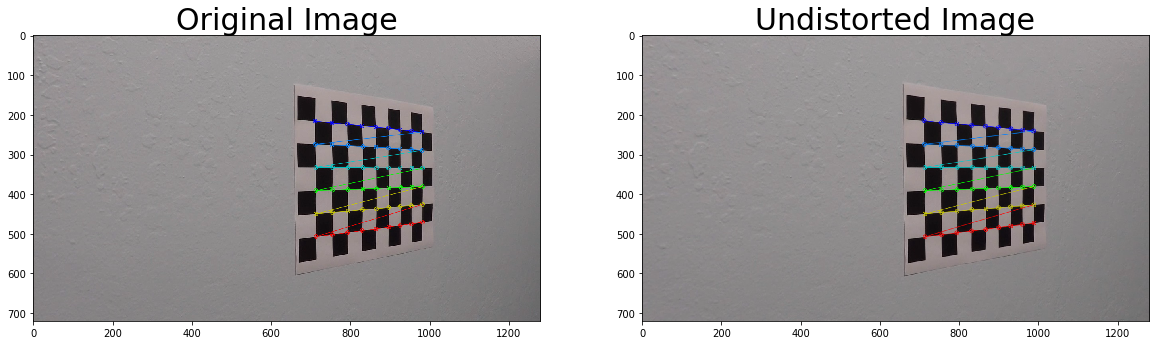

In [171]:
calibrated = calibrate_camera(image, obj_points, img_points)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(calibrated)
ax2.set_title('Undistorted Image', fontsize=30)

# Load Test Images

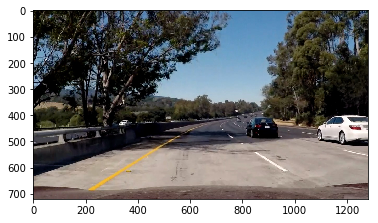

In [713]:
def load_road_images():
    road_images = []
    paths = glob.glob('test_images/*.jpg')
    for path in paths: 
        road_images.append(cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB))
        
    return road_images

road_images = load_road_images()    
road_image_num = 1
road_image = road_images[road_image_num]
plt.imshow(road_image)

# Undistorted Image

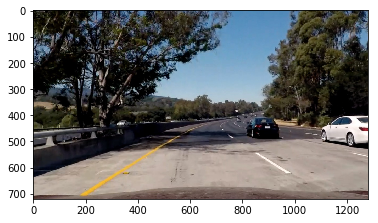

In [714]:
undistorted_image = calibrate_camera(road_image, obj_points, img_points)
plt.imshow(undistorted_image)

# Gradient Threshold Testing

## Gray x and y threshold

Text(0.5,1,'y image')

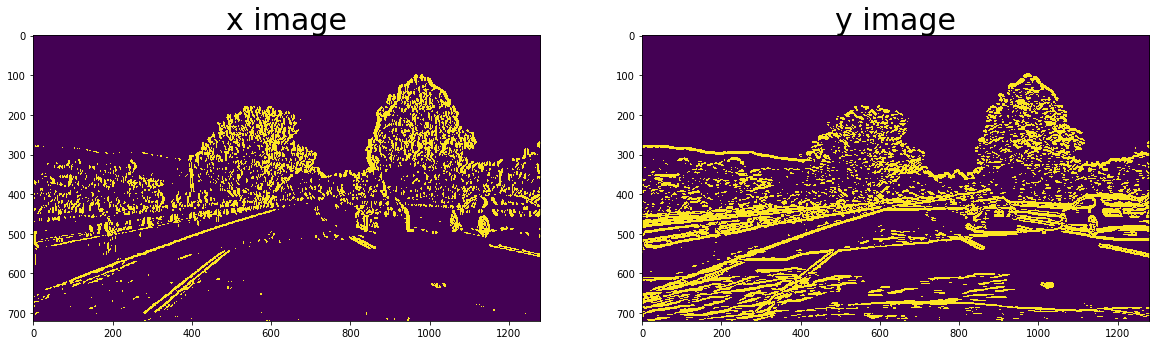

In [574]:
def abs_sobel_threshold(img_channel, orient='x', sobel_kernel=3, thresh=(0, 255)):
    sobel_x_param = 1 if orient == 'x' else 0
    sobel_y_param = 1 if orient == 'y' else 0
    sobel = cv2.Sobel(img_channel, cv2.CV_64F, sobel_x_param, sobel_y_param, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sbinary = np.zeros_like(scaled_sobel)
    thresh_min, thresh_max = thresh
    sbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    return sbinary

x_gray_binary = abs_sobel_threshold(to_gray(undistorted_image), orient='x', thresh=(20, 255), sobel_kernel=15)
y_gray_binary = abs_sobel_threshold(to_gray(undistorted_image), orient='y', thresh=(20, 255), sobel_kernel=15)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(x_gray_binary)
ax1.set_title('x image', fontsize=30)
ax2.imshow(y_gray_binary)
ax2.set_title('y image', fontsize=30)

## Magnatude Threshold

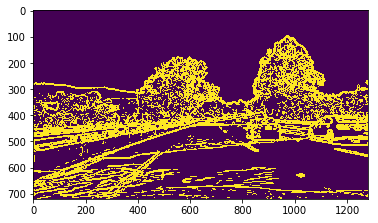

In [575]:
def mag_threshold(img_channel, sobel_kernel=3, mag_thresh=(0, 255)):
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(img_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    mag = np.sqrt(np.square(sobelx) + np.square(sobely))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*mag/np.max(mag))
    # 5) Create a binary mask where mag thresholds are met
    thresh_min, thresh_max = mag_thresh
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

mag_gray_thresh = mag_threshold(to_gray(undistorted_image), mag_thresh=(20, 255), sobel_kernel=15)
plt.imshow(mag_gray_thresh)

# Direction Threshold

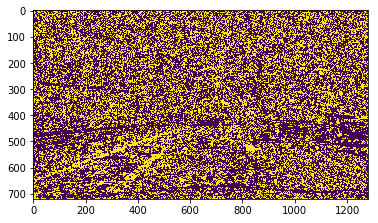

In [576]:
def dir_threshold(img_channel, sobel_kernel=3, thresh=(0, np.pi/2)):
    sobelx = cv2.Sobel(img_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction = np.arctan2(abs_sobely, abs_sobelx)
    scaled_sobel = direction
    # 5) Create a binary mask where direction thresholds are met
    thresh_min, thresh_max = thresh
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    return sbinary

dir_gray_threshold = dir_threshold(to_gray(undistorted_image), sobel_kernel=15, thresh=(0.7, 1.3))
plt.imshow(dir_gray_threshold)

# Combine Thresholds

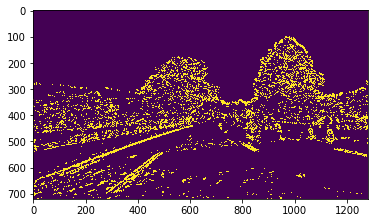

In [577]:
combined_gray = np.zeros_like(dir_gray_threshold)
combined_gray[((x_gray_binary == 1) & (y_gray_binary == 1)) | ((mag_gray_thresh == 1) & (dir_gray_threshold == 1))] = 1
plt.imshow(combined_gray)

# Color Thresholding

In [578]:
def channel_threshhold(image_channel, thresh=(150, 255)):
    min_thresh, max_thresh = thresh
    binary = np.zeros_like(image_channel)
    binary[(image_channel > min_thresh) & (image_channel <= max_thresh)] = 1
    return binary

def to_hls(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

def to_r(image):
    return image[:, :, 0]

def to_g(image):
    return image[:, :, 1]

def to_b(image):
    return image[:, :, 2]

def to_h(image):
    hls = to_hls(image);
    return hls[:,:,0]

def to_l(image):
    hls = to_hls(image);
    return hls[:,:,1]
    
def to_s(image):
    hls = to_hls(image);
    return hls[:,:,2]  

## Gray Thresholding

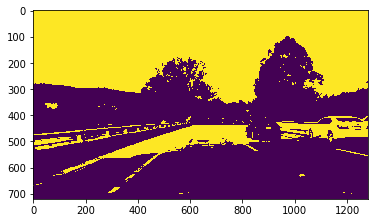

In [579]:
plt.imshow(channel_threshhold(to_gray(undistorted_image),  thresh=(150, 255)))

## Visualize RGB

Text(0.5,1,'Green')

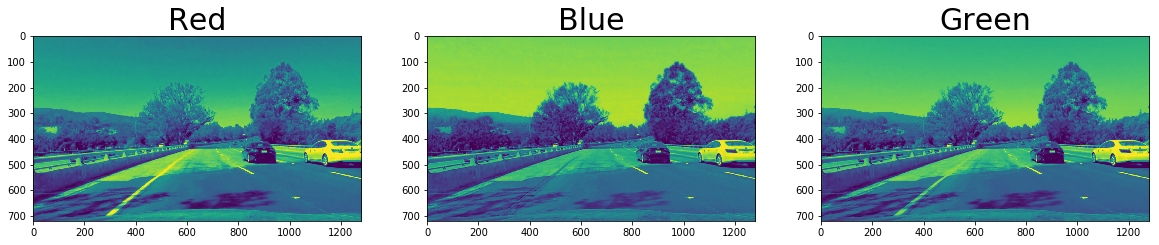

In [580]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(to_r(undistorted_image))
ax1.set_title('Red', fontsize=30)
ax2.imshow(to_b(undistorted_image))
ax2.set_title('Blue', fontsize=30)
ax3.imshow(to_g(undistorted_image))
ax3.set_title('Green', fontsize=30)

## Visualize HLS

Text(0.5,1,'Saturation')

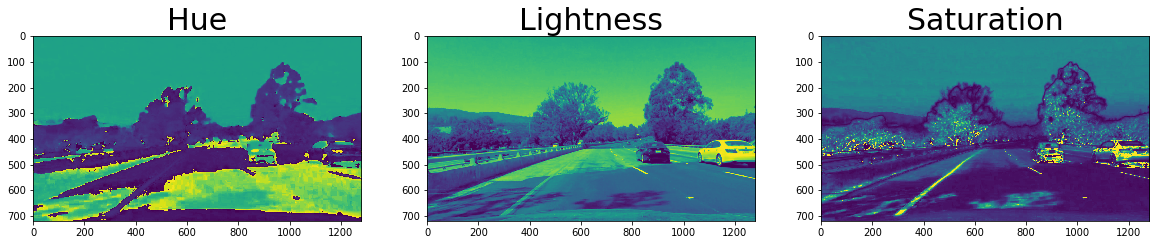

In [581]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(to_h(undistorted_image))
ax1.set_title('Hue', fontsize=30)
ax2.imshow(to_l(undistorted_image))
ax2.set_title('Lightness', fontsize=30)
ax3.imshow(to_s(undistorted_image))
ax3.set_title('Saturation', fontsize=30)

## RGB Channel Threshold

Text(0.5,1,'Green')

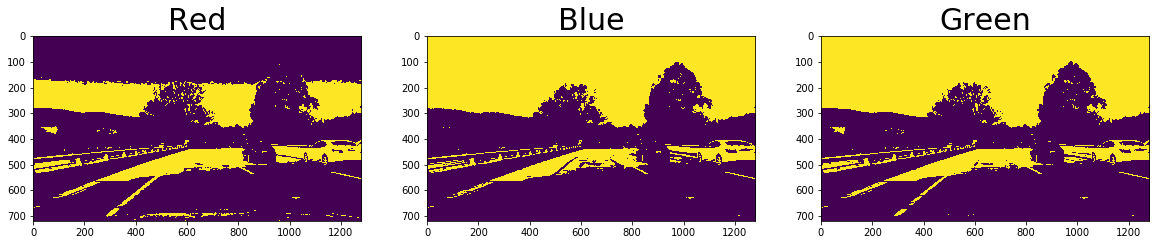

In [582]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(channel_threshhold(to_r(undistorted_image)))
ax1.set_title('Red', fontsize=30)
ax2.imshow(channel_threshhold(to_b(undistorted_image)))
ax2.set_title('Blue', fontsize=30)
ax3.imshow(channel_threshhold(to_g(undistorted_image)))
ax3.set_title('Green', fontsize=30)

## HLS Thresholds

Text(0.5,1,'Saturation')

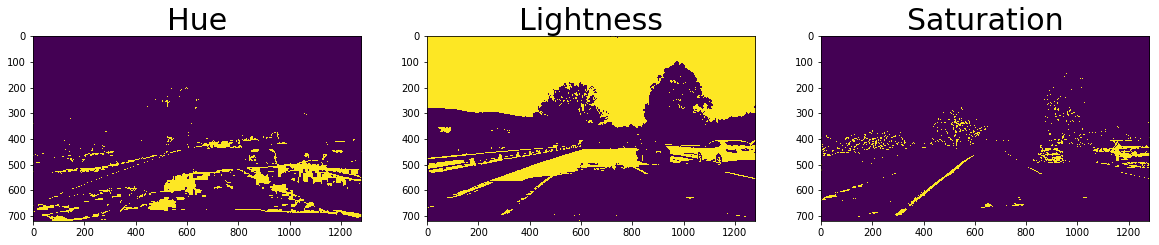

In [583]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(channel_threshhold(to_h(undistorted_image)))
ax1.set_title('Hue', fontsize=30)
ax2.imshow(channel_threshhold(to_l(undistorted_image)))
ax2.set_title('Lightness', fontsize=30)
ax3.imshow(channel_threshhold(to_s(undistorted_image)))
ax3.set_title('Saturation', fontsize=30)

## Color and Gradient

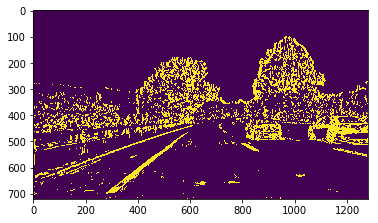

In [584]:
s_color_thresh = channel_threshhold(to_s(undistorted_image))

combined_x_s = np.zeros_like(x_gray_binary)
combined_x_s[(s_color_thresh == 1) | (x_gray_binary == 1)] = 1
plt.imshow(combined_x_s)

# Perspective Transform

## Find Points

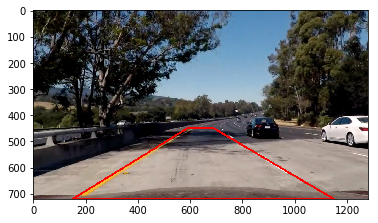

In [715]:
width, height = to_gray(undistorted_image).shape[::-1]
top = 450
thickness = 5

top_right = [690, top]
bottom_right = [1150, height]
bottom_left = [150, height]
top_left =[590, top]

pts = np.array([top_left, top_right, bottom_right, bottom_left])
pts = pts.reshape((-1,1,2))
lines = cv2.polylines(np.copy(undistorted_image),[pts],True,(255,0,0), thickness=thickness)

plt.imshow(lines)

# Warp Image

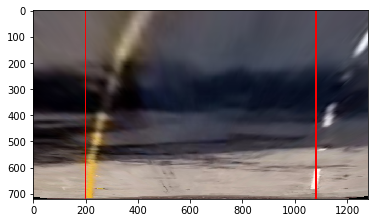

In [716]:
offset = 200
width, height = to_gray(undistorted_image).shape[::-1]

dst_top_right = [width - offset, 0]
dst_bottom_right = [width - offset, height]
dst_bottom_left = [offset, height]
dst_top_left = [offset, 0]

def warp(image, src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    return cv2.warpPerspective(image, M, to_gray(image).shape[::-1])
    
    
src = np.float32([top_right, bottom_right, bottom_left, top_left])
dst = np.float32([dst_top_right, dst_bottom_right, dst_bottom_left, dst_top_left])


warped = warp(undistorted_image, src, dst)
cv2.line(warped, tuple(dst_bottom_left), tuple(dst_top_left), (255,0,0), thickness=thickness)
cv2.line(warped, tuple(dst_bottom_right), tuple(dst_top_right), (255,0,0), thickness=thickness)


plt.imshow(warped)